# Run model with just SEI, Li+ concentration in the electrolyte eventually increases as porosity decrease. As some point, the large c(Li+) will fail all polynomial forms of electrolyte property (diffusivity and conductivity and give wrong results). If we take the form of exponential, that can ensure low diffusivity and conductivity, but that seems to cause some numerical problems.

In [1]:
# import modules
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;
from scipy.io import savemat,loadmat;from pybamm import constants,exp,tanh,sqrt;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import traceback
import imageio.v2 as imageio


In [2]:
font = {'family' : 'DejaVu Sans',
        #'weight' : 'bold',
        'size'   : 15}
mpl.rc('font', **font)

In [3]:
# import function 
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2_Crack_simp import (
    GetScan,
    recursive_scan,
    GetSol_dict,
    Para_init,
    Run_model_wwo_dry_out ,
    Cal_new_con_Update,
    Run_Model_Base_On_Last_Solution,
    Run_Model_Base_On_Last_Solution_RPT,
    write_excel_xlsx,
    Get_initial_cap,
    Get_initial_cap2,
    Plot_Loc_Var_sol
)

Para_0.search('mole')

In [4]:
from numpy import exp,sqrt
def electrolyte_diffusivity_Nyman2008Exp(c_e,c_EC, T):
    D_c_e = (
        6 * exp( -1 *(c_e/1000)) 
        * exp(-5/298.15) 
        * exp(-95/298.15*(c_e/1000)) * 1e-10 
    )
    return D_c_e

def electrolyte_conductivity_Nyman2008Exp(c_e,c_EC, T):
    sigma_e = (
        0.1 * 0.06248 * (1+298.15-0.05559) * 
        (c_e/1e3) * (1 - 3.084 *sqrt(c_e/1e3) 
        + 1.33 *(1+ 0.03633 *(exp(1000/298.15))*c_e/1e3)   ) 
        / (1+(c_e/1e3)**4*( 0.00795 *exp(1000/298.15))) 
    )
    return sigma_e
print(electrolyte_diffusivity_Nyman2008Exp(10,4541, 298.15))
print(electrolyte_conductivity_Nyman2008Exp(10,4541, 298.15))

5.822927088266968e-10
0.03803688841420761


In [5]:
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R5/'; 
Target  = 'High_c(Li+)_Nyman2008Exp/'
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);

In [6]:
pybamm.settings.tolerances['D_e__c_e'] = 1e-15
print(pybamm.settings.tolerances)

{'D_e__c_e': 1e-15, 'kappa_e__c_e': 10, 'chi__c_e': 0.01, 'U__c_s': 1e-10, 'j0__c_e': 1e-08, 'j0__c_s': 1e-08, 'macinnes__c_e': 1e-15}


In [12]:
# set-up and run model
V_max = 4.2;        V_min = 2.5;
total_cycle = 1; save_at_cycles= 1
Experiment_Long   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V (1 minutes period)" ,     )] * total_cycle ) 
Experiment_s   = pybamm.Experiment( [ (
    f"Discharge at 1 C for 20 minutes (10 seconds period)" , )] * total_cycle ) 

Elely = ["lipf6_Nyman2008Exp","lipf6_Nyman2008"]
Sim = [];Sol=[]; 
for elely in Elely:
    ChemistryChen=pybamm.parameter_sets.Chen2020 
    ChemistryChen["electrolyte"] = elely
    Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
    Para_0['Negative electrode porosity'] =  0.1
    #print(Model_d.options["solvent diffusion"])
    Para_0['Ratio of lithium moles to SEI moles'] =  1
    model = pybamm.lithium_ion.DFN()
    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    c_EC = model.variables["EC concentration [mol.m-3]"]
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    model.variables["Electrolyte conductivity [S.m-1]"] =(
        Para_0['Electrolyte conductivity [S.m-1]'](c_e,c_EC, T))
    model.variables["Electrolyte diffusivity [m2.s-1]"] =(
        Para_0['Electrolyte diffusivity [m2.s-1]'](c_e,c_EC, T))
    var = pybamm.standard_spatial_vars  
    mesh_thick = 100; mesh_par=30;
    var_pts = {
        var.x_n: int(mesh_thick),  
        var.x_s: int(20),  
        var.x_p: int(mesh_thick),  
        var.r_n: int(mesh_par),  
        var.r_p: int(mesh_par),  }  
    sim = pybamm.Simulation(
        model, experiment = Experiment_s,
        parameter_values = Para_0,
        solver = pybamm.CasadiSolver(),
        var_pts=var_pts,)  
    try:
        sol = sim.solve(save_at_cycles=save_at_cycles,);
        print(sol.cycles[-1].steps[-1]);  # a way to check whether the solution is finalized 
    except:
        print('Fail for electrolyte: ',elely)
    else:
        Sol.append(sol)   
        print('Succeed for electrolyte: ',elely)

Succeed for electrolyte:  lipf6_Nyman2008Exp
Succeed for electrolyte:  lipf6_Nyman2008


In [13]:
print(len(Sol[0]["Electrolyte conductivity [S.m-1]"].entries[0,:] ))

121


In [14]:
print(Sol[0]["Electrolyte conductivity [S.m-1]"].entries [:,6] )

[0.41708641 0.41704456 0.41696097 0.41683584 0.41666949 0.41646233
 0.41621489 0.41592784 0.41560191 0.41523802 0.41483716 0.4144005
 0.41392931 0.41342504 0.41288928 0.41232379 0.41173053 0.41111161
 0.41046937 0.40980636 0.40912538 0.40842947 0.40772193 0.40700637
 0.40628672 0.40556724 0.40485257 0.40414775 0.40345823 0.40278997
 0.40214939 0.4015435  0.40097986 0.40046669 0.40001288 0.39962805
 0.39932262 0.39910783 0.39899583 0.39899968 0.39913348 0.39941236
 0.39985252 0.40047132 0.40128729 0.40232012 0.40359072 0.40512119
 0.40693479 0.40905593 0.41151008 0.4143237  0.41752416 0.42113954
 0.42519857 0.42973039 0.43476437 0.44032992 0.44645624 0.45317206
 0.46050541 0.4684833  0.47713142 0.48647379 0.4965324  0.50732673
 0.51887329 0.53118504 0.54427068 0.55813389 0.57277245 0.58817721
 0.60433094 0.62120707 0.6387684  0.65696564 0.67573606 0.69500217
 0.71467058 0.7346311  0.75475628 0.77490146 0.79490549 0.81459219
 0.83377269 0.85224857 0.86981595 0.88627016 0.90141103 0.91504

In [15]:
print(Sol[0]["Electrolyte concentration [mol.m-3]"].entries[:,21] )
print(Sol[0]["Electrolyte conductivity [S.m-1]"].entries[:,21] )
#print(Sol[0]["Electrolyte diffusivity [m2.s-1]"].entries[:,10])

[4586.70721973 4587.4792083  4589.02291106 4591.33745268 4594.42127977
 4598.27203547 4602.88638049 4608.25975298 4614.38605674 4621.25726378
 4628.86291335 4637.18948385 4646.21960786 4655.93109175 4666.29569077
 4677.27757687 4688.83141879 4700.89997217 4713.41104957 4726.27370608
 4739.3734352  4752.56612289 4765.67045789 4778.45845353 4790.64371738
 4801.86714618 4811.67988649 4819.52379082 4824.71037244 4826.40063096
 4823.59029738 4815.10809196 4799.63806759 4775.77956809 4742.15682805
 4697.5808013  4641.24603917 4572.91958414 4493.06129754 4402.82409627
 4303.92229417 4198.40522046 4088.40255631 3975.90690183 3862.63319822
 3749.95834691 3638.92134498 3530.25992032 3424.46280875 3321.82394141
 3222.49129622 3126.50736503 3033.84102239 2944.41171187 2858.10721456
 2774.79635679 2694.33817617 2616.58837631 2541.40339423 2468.64294961
 2398.17192714 2329.86168782 2263.59065925 2199.2443653  2136.71522671
 2075.90233292 2016.71120936 1959.05354149 1902.84683883 1848.0140557
 1794.4

In [16]:
label = [elely for elely in Elely]
output_variables3 = [
    "Terminal voltage [V]",   
    "Electrolyte potential [V]",
    "Electrolyte concentration [mol.m-3]",
    "Li+ flux [mol.m-2.s-1]",
    "Electrolyte diffusivity [m2.s-1]",
    "Electrolyte conductivity [S.m-1]"
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol], 
    output_variables3,label,
    variable_limits='tight',time_unit='minutes',n_rows=2,
    figsize = (12,8)) #     spatial_unit='mm',
quick_plot.dynamic_plot();
#quick_plot.plot(0.5)
#quick_plot.fig.savefig(BasicPath + Target+"t_0+_three_cases.png", dpi=600)
quick_plot.create_gif(
    number_of_images=30, duration=4,output_filename=BasicPath + Target+"Set_tolerance_All_figures.gif")

interactive(children=(FloatSlider(value=0.0, description='t', max=20.0, step=0.2), Output()), _dom_classes=('w…

In [17]:
output_variables3 = [
    "Terminal voltage [V]",   
    "Electrolyte potential [V]",
    "Electrolyte concentration [mol.m-3]",
    "Li+ flux [mol.m-2.s-1]",
    "Electrolyte diffusivity [m2.s-1]",
    "Electrolyte conductivity [S.m-1]"
]
quick_plot = pybamm.QuickPlot(
    Sol[0], 
    output_variables3,
    variable_limits='tight',time_unit='hours',n_rows=2,
    figsize = (12,8)) #     spatial_unit='mm',
quick_plot.dynamic_plot();
#quick_plot.plot(0.5)
#quick_plot.fig.savefig(BasicPath + Target+"t_0+_three_cases.png", dpi=600)
#quick_plot.create_gif(
#    number_of_images=10, duration=2,output_filename=BasicPath + Target+"concentration and flux.gif")

interactive(children=(FloatSlider(value=0.0, description='t', max=0.3333333333333333, step=0.00333333333333333…

(<Figure size 1512x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Electrolyte concentration [mol.m-3]'}, xlabel='x [m]'>,
        <AxesSubplot:title={'center':'Electrolyte potential [V]'}, xlabel='x [m]'>,
        <AxesSubplot:title={'center':'Porosity'}, xlabel='x [m]'>],
       dtype=object))

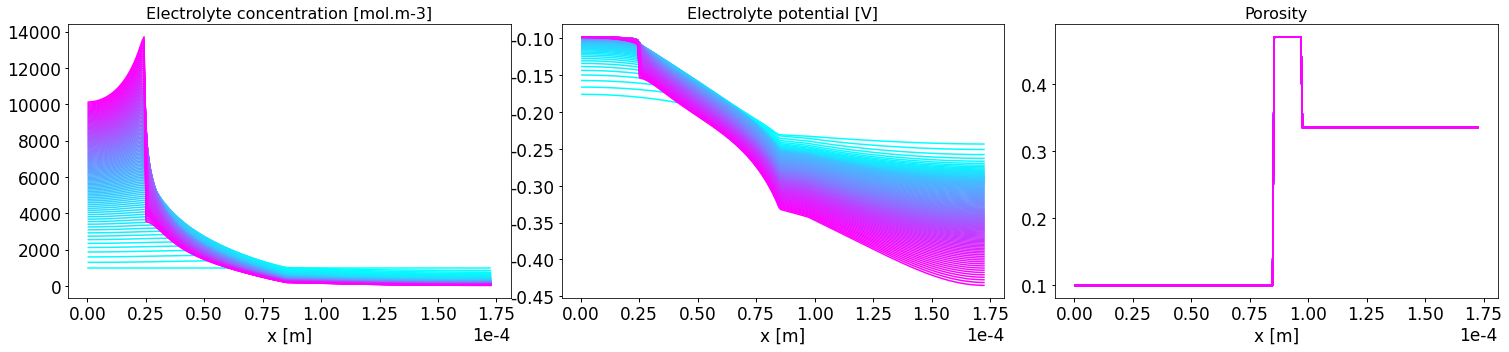

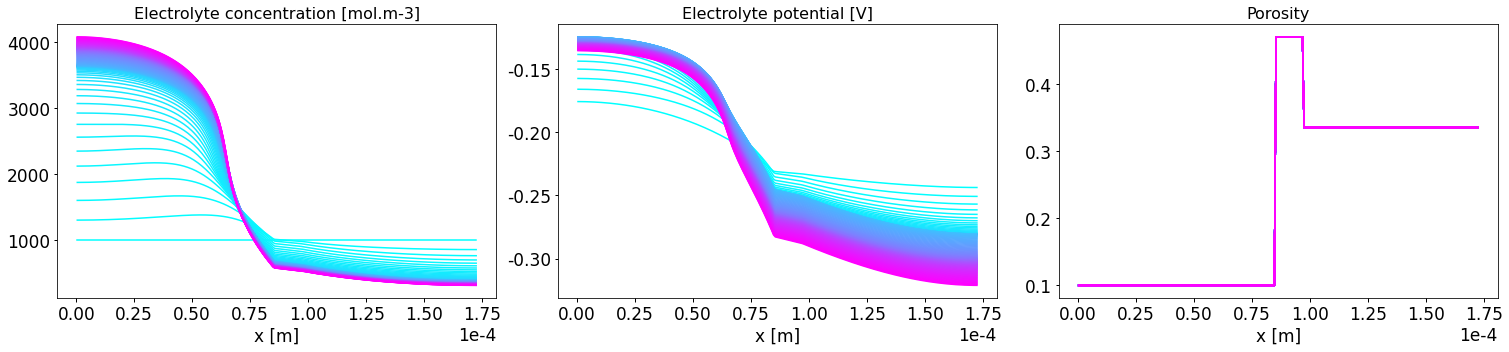

In [18]:
Plot_Loc_Var_sol(
    Sol[0],
    ["x [m]","x [m]","x [m]"], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]","Porosity",], 
    0,0,'cool')
Plot_Loc_Var_sol(
    Sol[1],
    ["x [m]","x [m]","x [m]"], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]","Porosity",], 
    0,0,'cool')

(<Figure size 1008x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Electrolyte diffusivity [m2.s-1]'}, xlabel='x [m]'>,
        <AxesSubplot:title={'center':'Electrolyte conductivity [S.m-1]'}, xlabel='x [m]'>],
       dtype=object))

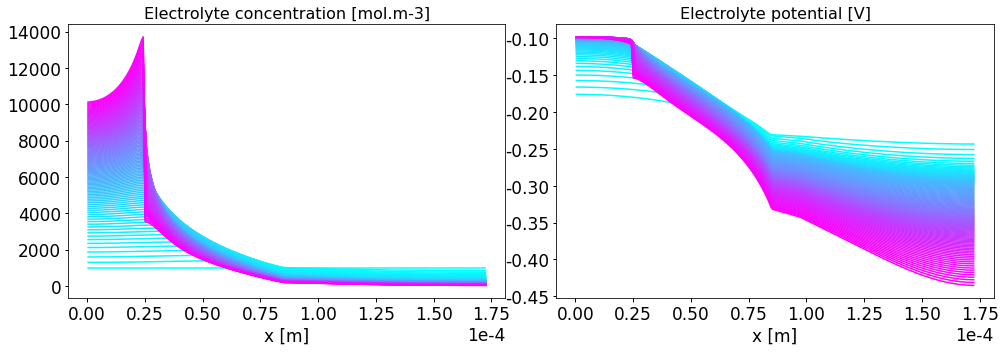

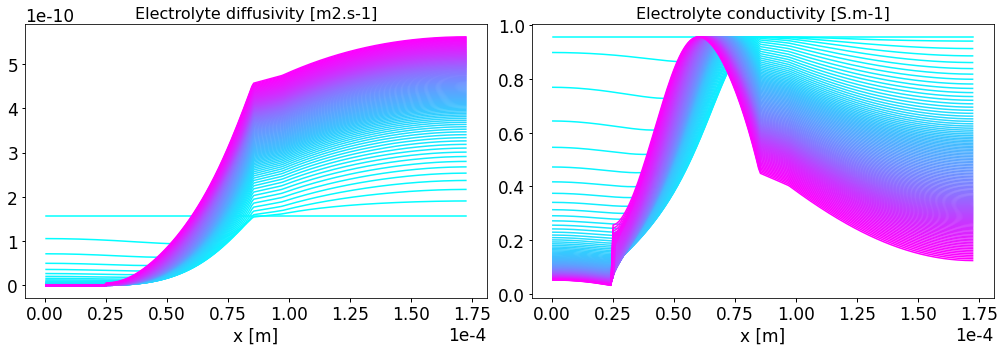

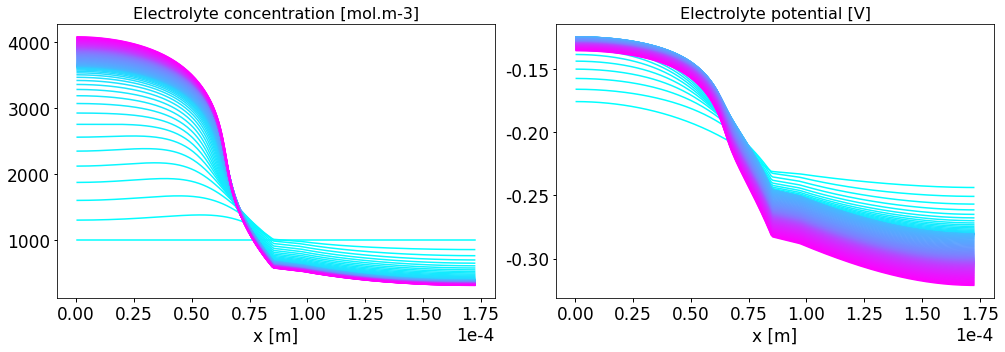

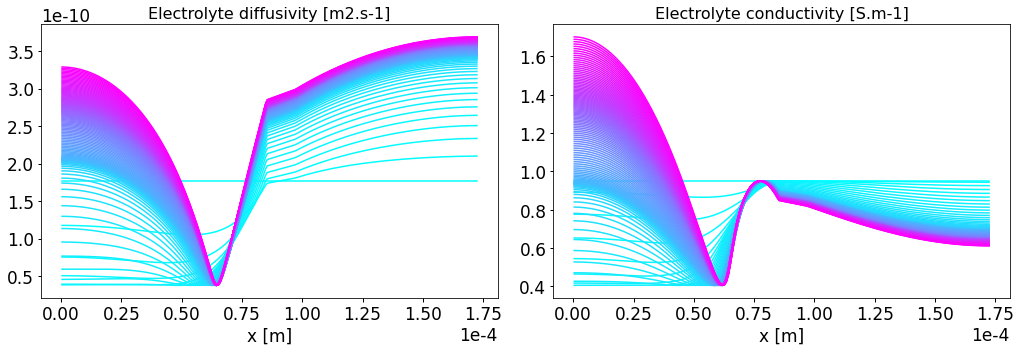

In [19]:
Plot_Loc_Var_sol(
    Sol[0],
    ["x [m]","x [m]",], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]"], 
    0,0,'cool')
Plot_Loc_Var_sol(
    Sol[0],
    ["x [m]","x [m]",], 
    ["Electrolyte diffusivity [m2.s-1]","Electrolyte conductivity [S.m-1]"], 
    0,0,'cool')


Plot_Loc_Var_sol(
    Sol[1],
    ["x [m]","x [m]",], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]"], 
    0,0,'cool')
Plot_Loc_Var_sol(
    Sol[1],
    ["x [m]","x [m]",], 
    ["Electrolyte diffusivity [m2.s-1]","Electrolyte conductivity [S.m-1]"], 
    0,0,'cool')

IndexError: list index out of range

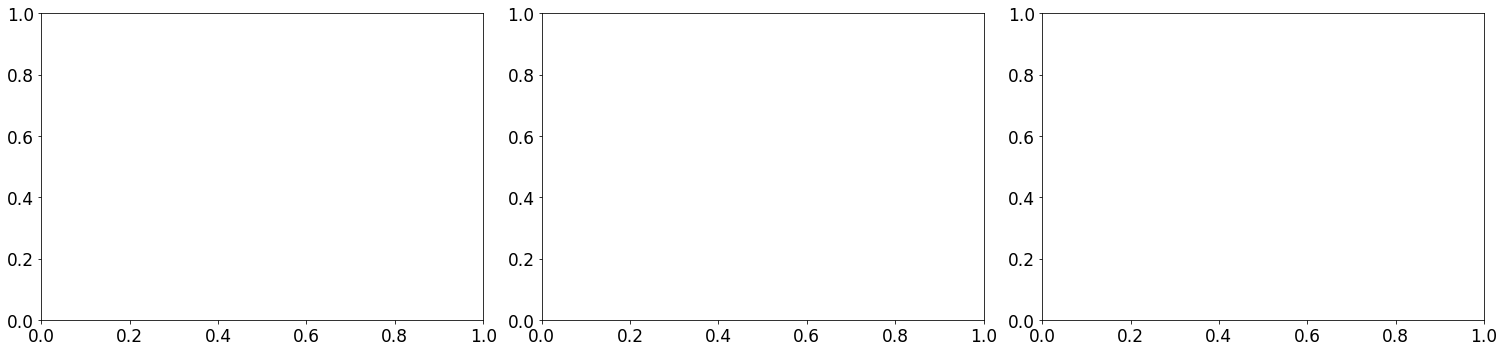

In [20]:
Plot_Loc_Var_sol(
    Sol[0],
    ["x [m]","x [m]","x [m]"], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]","Porosity",], 
    0,1,'cool')
Plot_Loc_Var_sol(
    Sol[1],
    ["x [m]","x [m]","x [m]"], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]","Porosity",], 
    0,1,'cool')